# <center> <font color='blue'> **A Deep Learning Architechture for Passive Microwave Precipitation Retrievals** <center>

#### <center> <font color='balck'> Reyhaneh Rahimi, Sajad Vahedizade, Ardeshir Ebtehaj <center>
#### <center> Saint Anthony Falls Laboratory, Department of Civil Environmental and Geo- Engineering, 
#### <center> University of Minnesota <center>
#### <center> Date: October, 2022 (rev 01)

---
<p align="justify"> This notebook representes the results of an algorithm, called the Deep precIpitation rEtrieval alGOrithm (DIEGO) for passive microwave retrieval of precipitation. The algorithm relies on a dense and deep neural network architecture that uses coincidences of brightness temperatures (TB) from the Global Precipitation Measurment (GPM) satellite Microwave Imager (GMI) and active precipitation retrievals from the Dual-frequency Precipitation Radar (DPR) onboard the GPM as well as those from the CloudSat Cloud Profiling Radar (CPR). The algorithm first detects the precipitation occurrence and phase and then estimates its rate, while conditioning the results to some key cloud microphysical and environmental variables as further explained later on in Section 1.2. The results indicate that we can reconstruct the DPR rainfall and CPR snowfall with the detection probability of more than 0.95 while the probability of false alarm remains below 0.08 and 0.03, respectively. Given that precipitation is occurred, the unbiased root mean squared errors in estimation of rainfall (snowfall) rate using DPR (CPR) data is less than 0.8 (0.1) $\rm mm.hr^{-1}$ over oceans and land. Beyond methodological developments, comparing the results with ERA5 reanalysis and official GPM products demonstrates that the uncertainty in global satellite snowfall retrievals continues to be large while there is a good agreement among rainfall products. Moreover, the results indicate that CPR active snowfall data can improve passive microwave estimates of global snowfall while the CPR rainfall should only be used for detection and not estimation of rates. 

This notebook is organized as follows. Section 1, describes the data including the GPM and CloudSat products as well as the ERA5 reanalysis data from the European Centre for Medium-Range Weather Forecasts (ECMWF). Section 2 describes the methodolgy for training the networks, and the last section provides an example for precipitation orbital retrieval using the proposed algorithm.





   


# **1.  Data**

## **1.1** **Data Description**

In this study, we use near-coincident observations of GMI and CPR from March 2014 to August 2016 ([1](https://www.mdpi.com/2072-4292/13/12/2264)), and coincidences of GMI and DPR data in 2015. Furthermore, ancillary information of 2-m air temperature, cloud liquid and ice water paths, and convective available potential energy (CAPE) are added to all coincidences using the [ERA5](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5) reanalysis products -- available at spatial resolution of 31~km. 

The GMI-CPR coincidences rely on the level-II CloudSat products (R05) including the 2C-PRECIP-COLUMN  and the 2C-SNOW-PROFILE that contains near-surface rain and snowfall rates.  To avoid ground-clutter contamination over complex elevated terrains, the near-surface snowfall rate is reported at 3rd (5th) radar bin above the oceans (land) at 720 (1200) m above the surface.

The 2A-DPR product, retrieved from Ku-band reflectivity, consists the near-surface precipitation phase and its intensity. It should be noted that the DPR algorithm uses precipitation phase at the lowest radar range gate uncontaminated by surface clutter, which may be 0.5--2.0 km above the surface (even over oceans). 

Figure 1, represents the way the coincidences between GMI and CloudSat profiling radar (CPR) and GMI and DPR are collected. For more details with respect to the CloudSat and GMI please refer to ([2](https://journals.ametsoc.org/view/journals/hydr/22/7/JHM-D-20-0296.1.xml)).

Throughout, the GMI--DPR and GMI--CPR databases are divided based on different surface types including ocean, land, and coastal zones using the information provided by the Goddard Profiling Algorithm([GPROF](https://journals.ametsoc.org/view/journals/apme/40/11/1520-0450_2001_040_1801_teotgp_2.0.co_2.xml)).

 

<p align="center"> <img src ='https://drive.google.com/uc?id=1TIRaIKq8aV4O0rceWroF-FBp6a6S9SS8' align = "center">


***Figure 1***.  Schematic of a CloudSat-GPM coincidence segment (left), and DPR-GMI coincidence (right)

In summary, the *priori* database contains 40E+6 (5.5E+6) number of GMI-DPR (GMI-CPR) coincidences over oceans. The number of coincidences are 6.5E+6 (2E+6) over land and 2E+6 (6E+5) over coastal zones. Samples of these databases will be used to train, validate, and test the proposed retrieval algorithm. The GMI observations are from the calibrated TBs (1C.GPM.GMI, V05). The coincidences with DPR are reported at 5~km spacing where both S1 (10--89 GHz) and S2 (166--183 GHz) GMI channels have overlapping observations.


## **1.2 Database Organization and Loading**
As previously mentioned, GMI--DPR and GMI--CPR databases are stratified based on different surface types including ocean, land, and coastal zones. Therefore, in this paper there are 6 different training datasets for CPR (ocean, coast, land) and DPR (ocean, coast, land). 

In each data set, there are three different sub datasets for (i) phase detection, (ii) rainfall and (iii) snowfall estimation. These data are organized into a set of matrices. The input matrices for training of each network is represent by $X_{train} \in \mathbb{R}^{m×n}$, where $m$ is the number of sampels and $n$ is the number of features. The outputs lables and precipitation values are stored in $Y_{train} \in \mathbb{R}^{m}$.  


**For the phase detection, the inputs and outputs are as follows:**
> **Inputs:**

*   $\text{TB} = X_{train}(:,1:13)$ (Brightness Temperature at 13 GMI channels [K])
*   $ \text{LWP} = X_{train}(:,14)$ (Cloud Liquid Water Path)
*   $\text{IWP} = X_{train}(:,15)$ (Cloud Ice Water Path)
*   $\text{T2m} = X_{train}(:,16)$ (2-meter Air Temperature)
*   $\text{WVP} = X_{train}(:,17)$ (Water Vapor Path)
*   $\text{CAPE} = X_{train}(:,18)$ (Convective Potential Energy)

> **Outputs:**

*   Output of the phase network is a vector containing three integer values **1 (snowfall)**, **2 (rainfall)**, and **3 (no precipitation)**

**For the precipitation estimation, the inputs and outputs are as follows:**

> **Inputs:**

*    $\text{TB} = X_{train}(:,1:13)$ (Brightness Temperature at 13 GMI channels [K])
*   $X_k = X_{train}(:,14:33)$  (Snowfall/rainfall rate of *k*-nearest neighbors ($k=20$) of the observed TBs in the training set.)

> **Outputs**:

*   Output of the estimation network is a vector containing rainfall/snowfall rate [$\rm mm.hr^{-1}$].

From the collected coincidences only 1E+6 number of data points over land and oceans are used for tuning the network parameters. To avoid overfitting, we split the tuning database of DPR and CPR coincidences into training (70\%), validation (15\%), and testing (15\%) data sets. 

In the next section the DPR coincidences is loaded to show the the training, testing, and validation data and their size. 
The filename code for each dictionary is *Dic_ds_st_v2.mat*, where "ds" is either DPR or CPR and "st" represents the surface types. Here Dic_DPR_ocean_v2.mat contains a dataset for DPR coincidences over ocean.


In [ ]:
import os
import h5py
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/DNN-Github/Network')
data = h5py.File("Dic_DPR_ocean_v2.mat",'r')
list(data.keys())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['X_ocean_trn_detection',
 'X_ocean_tst_detection',
 'X_rain_ocean_trn_retrieval',
 'X_rain_ocean_tst_retrieval',
 'X_snow_ocean_trn_retrieval',
 'X_snow_ocean_tst_retrieval',
 'y_ocean_trn_detection',
 'y_ocean_tst_detection',
 'y_rain_ocean_trn_retrieval',
 'y_rain_ocean_tst_retrieval',
 'y_snow_ocean_trn_retrieval',
 'y_snow_ocean_tst_retrieval']

## **1.3 Data Normalization**

The input features for training have different ranges and units, therefore they need to be scaled to make the flow of the gradient decsent smooth and help the algorithm quickly reaches the optimal point of the cost function. Without scaling features, the algorithm may be biased toward those features which have larger magnitues. We used the following standardization:

$X_i^{\prime} = \frac{X_i - \mu}{σ}$

In the above equation $X_i^{\prime}$ is the scaled feature, $μ$ is the mean, and $σ$ is the standard deviation of the feature. In the next cell, we implement this scaling for the data sets. 

In [ ]:
#@title ######  **Click here to see the normalization function**

import numpy as np
def preprocessing_DPR(data):

# Load the data from the dictionary
  X1_trn_detection = np.transpose(data['X_ocean_trn_detection'])
  y_trn_detection = np.transpose(data['y_ocean_trn_detection'])
  X1_tst_detection = np.transpose(data['X_ocean_tst_detection'])
  y_tst_detection = np.transpose(data['y_ocean_tst_detection'])

  X1_rain_trn_retrieval = np.transpose(data['X_rain_ocean_trn_retrieval'])
  y_rain_trn_retrieval = np.transpose(data['y_rain_ocean_trn_retrieval'])
  X1_rain_tst_retrieval = np.transpose(data['X_rain_ocean_tst_retrieval'])
  y_rain_tst_retrieval = np.transpose(data['y_rain_ocean_tst_retrieval'])

  X1_snow_trn_retrieval = np.transpose(data['X_snow_ocean_trn_retrieval'])
  y_snow_trn_retrieval = np.transpose(data['y_snow_ocean_trn_retrieval'])
  X1_snow_tst_retrieval = np.transpose(data['X_snow_ocean_tst_retrieval'])
  y_snow_tst_retrieval = np.transpose(data['y_snow_ocean_tst_retrieval'])

#change the type of the inputs to float 64 and the type of phase labels to int64
  X1_trn_detection.astype('float64')
  X1_tst_detection.astype('float64')
  y_trn_detection.astype('int64')
  y_tst_detection.astype('int64')

  X1_rain_trn_retrieval.astype('float64')
  X1_rain_tst_retrieval.astype('float64')
  y_rain_trn_retrieval.astype('float64')
  y_rain_tst_retrieval.astype('float64')

  X1_snow_trn_retrieval.astype('float64')
  X1_snow_tst_retrieval.astype('float64')
  y_snow_trn_retrieval.astype('float64')
  y_snow_tst_retrieval.astype('float64')

# Calculatiing the mean and standard deviation of features in the training dataset and do the standardization
  mean_detection  = X1_trn_detection.mean(axis=0)
  std_detection   = X1_trn_detection.std(axis=0)
  X_trn_detection = (X1_trn_detection-mean_detection)/std_detection
  X_tst_detection = (X1_tst_detection-mean_detection)/std_detection

  mean_rain_retrieval   = X1_rain_trn_retrieval.mean(axis=0)
  std_rain_retrieval    = X1_rain_trn_retrieval.std(axis=0)
  X_rain_trn_retrieval  = (X1_rain_trn_retrieval-mean_rain_retrieval)/std_rain_retrieval
  X_rain_tst_retrieval  = (X1_rain_tst_retrieval-mean_rain_retrieval)/std_rain_retrieval

  mean_snow_retrieval   = X1_snow_trn_retrieval.mean(axis=0)
  std_snow_retrieval    = X1_snow_trn_retrieval.std(axis=0)
  X_snow_trn_retrieval  = (X1_snow_trn_retrieval-mean_snow_retrieval)/std_snow_retrieval
  X_snow_tst_retrieval  = (X1_snow_tst_retrieval-mean_snow_retrieval)/std_snow_retrieval

# Removing the outliers (removing the )
  x_snow_lb = 0.0  
  x_snow_ub = np.percentile(y_snow_trn_retrieval,99.95)

  x_rain_lb = 0.0   
  x_rain_ub = np.percentile(y_rain_trn_retrieval,99.95)

  mask_trn_snow = (y_snow_trn_retrieval>=x_snow_lb) & (y_snow_trn_retrieval<=x_snow_ub)
  m_trn_snow    = mask_trn_snow[:,0]
  mask_tst_snow = (y_snow_tst_retrieval>=x_snow_lb) & (y_snow_tst_retrieval<=x_snow_ub)
  m_tst_snow=mask_tst_snow[:,0]

  mask_trn_rain = (y_rain_trn_retrieval>=x_rain_lb) & (y_rain_trn_retrieval<=x_rain_ub)
  m_trn_rain=mask_trn_rain[:,0]
  mask_tst_rain = (y_rain_tst_retrieval>=x_rain_lb) & (y_rain_tst_retrieval<=x_rain_ub)
  m_tst_rain=mask_tst_rain[:,0]

  Xf_snow_trn_detection = np.delete(X_trn_detection, ~m_trn_snow, axis=0)
  yf_snow_trn_detection = np.delete(y_trn_detection, ~m_trn_snow, axis=0)
  Xf_snow_tst_detection = np.delete(X_tst_detection, ~m_tst_snow, axis=0)
  yf_snow_tst_detection = np.delete(y_tst_detection, ~m_tst_snow, axis=0)

  Xf_snow_trn_retrieval = np.delete(X_snow_trn_retrieval, ~m_trn_snow, axis=0)
  yf_snow_trn_retrieval = np.delete(y_snow_trn_retrieval, ~m_trn_snow, axis=0)
  Xf_snow_tst_retrieval = np.delete(X_snow_tst_retrieval, ~m_tst_snow, axis=0)
  yf_snow_tst_retrieval = np.delete(y_snow_tst_retrieval, ~m_tst_snow, axis=0)

  Xf_rain_trn_detection = np.delete(X_trn_detection, ~m_trn_rain, axis=0)
  yf_rain_trn_detection = np.delete(y_trn_detection, ~m_trn_rain, axis=0)
  Xf_rain_tst_detection = np.delete(X_tst_detection, ~m_tst_rain, axis=0)
  yf_rain_tst_detection = np.delete(y_tst_detection, ~m_tst_rain, axis=0)

  Xf_rain_trn_retrieval = np.delete(X_rain_trn_retrieval, ~m_trn_rain, axis=0)
  yf_rain_trn_retrieval = np.delete(y_rain_trn_retrieval, ~m_trn_rain, axis=0)
  Xf_rain_tst_retrieval = np.delete(X_rain_tst_retrieval, ~m_tst_rain, axis=0)
  yf_rain_tst_retrieval = np.delete(y_rain_tst_retrieval, ~m_tst_rain, axis=0)

  return X_trn_detection, X_tst_detection, y_trn_detection, y_tst_detection, Xf_rain_trn_retrieval, Xf_rain_tst_retrieval,\
   yf_rain_trn_retrieval, yf_rain_tst_retrieval, Xf_snow_trn_retrieval, Xf_snow_tst_retrieval,yf_snow_trn_retrieval,yf_snow_tst_retrieval

In [ ]:
# Using the defined function for loading the data and normalizing the features.

X_trn_detection, X_tst_detection, y_trn_detection, y_tst_detection, X_rain_trn_retrieval, X_rain_tst_retrieval, y_rain_trn_retrieval, y_rain_tst_retrieval,\
X_snow_trn_retrieval, X_snow_tst_retrieval,y_snow_trn_retrieval,y_snow_tst_retrieval = preprocessing_DPR(data)

print('size of training dataset for detection module:',X_trn_detection.shape)
print('size of training dataset for snowfall retrieval module:',X_snow_trn_retrieval.shape)
print('size of training dataset for rainfall retrieval module:',X_rain_trn_retrieval.shape)

size of training dataset for detection module: (700000, 18)
size of training dataset for snowfall retrieval module: (699650, 33)
size of training dataset for rainfall retrieval module: (699650, 33)


To show that the labels are balanced in the training and test set, the number of snowfall, rainfall and no precipitation lables is printed in the next cell.

In [ ]:
print('***Training Dataset:\n')
n_snow=1
n_rain=1
n_clear=1  
t_train = np.zeros([y_trn_detection.shape[0],1])

for i in range(len(X_trn_detection)):
    label = y_trn_detection[i]
    if label==1:
        n_snow+=1
        t_train[i]=2
    if label==2:
        n_rain+=1  
        t_train[i]=1
    if label==3:
        n_clear+=1
        t_train[i]=0
        
print('Num. of snowfall:',n_snow)
print('Num. of rainfall:',n_rain)
print('Num. of clear-sky:',n_clear)

print('\n***Testing Dataset:\n')

n_snow = 1
n_rain = 1
n_clear= 1  
t_test = np.zeros([y_tst_detection.shape[0],1])

for i in range(len(X_tst_detection)):
    label = y_tst_detection[i]
    if label==1:
        n_snow+=1
        t_test[i]=2
    if label==2:
        n_rain+=1  
        t_test[i]=1
    if label==3:
        n_clear+=1
        t_test[i]=0
        
print('Num. of snowfall:',n_snow)
print('Num. of rainfall:',n_rain)
print('Num. of clear-sky:',n_clear)

***Training Dataset:

Num. of snowfall: 174722
Num. of rainfall: 175156
Num. of clear-sky: 350125

***Testing Dataset:

Num. of snowfall: 75143
Num. of rainfall: 75214
Num. of clear-sky: 149646


# **2.  METHODOLOGY**
We propose a sequence of DNNs to first *detect* the surface precipitation occurrence and its phase and then *estimate* its near surface rate. This architecture is guided through the KerasTuner Python library that trains a network with different configurations and hyperparameters (e.g., number of hidden layers, neural nodes) to find the best set of choices based on the defined cost function over a prespecified search space. The basic architecture of the algorithm is shown in Figure 2 for a specific surface type. Over oceans, land and coastal areas, we have two d-DNNs, one for DPR and one for CPR training data set. When the d-DNN detects precipitation and its phase, a phase specific e-DNN is deployed to approximate the rate of surface rain or snowfall. 

Therefore, for each land surface type, we have two d-DNNs and four e-DNNs.
In the next section, the training procedure is demonstrated for detection and estimation networks using DPR data over the ocean. 

Table 1 shows the detection accuracy based on the True Positive Rate
(TPR) or probability of detection and False Positive Rate (FPR) or probability of false alarm. Moreover, in Figure 3, the estimation scatter plots and the associated quality metrics are represented. 
 


 <center><img src ='https://drive.google.com/uc?id=1ks7RJ2b67JuyNhTZoDbP14yDw_dF-5Eg' align = "left"></center>

***Figure 2.*** The architecture of the Deep precIpitation rEtrieval alGOrithm (DIEGO) for a specific land surface type. As shown, in DIEGO a Deep Neural Network (DNN) first detects (d-DNN) the occurrence and phase of precipitation and then another one (e-DNN) estimates its rate. The inputs to the DNNs, number of layers $L$, and number neurons $n_l$ are shown for different training databases in the inset table.

|      |       |      |  CPR |      |       |      |
|:----:|:-----:|:----:|:----:|:----:|:-----:|:----:|
|      | Ocean |      | Land |      | Coast |      |
|      |  TPR  | FPR  | TPR  | FPR  |  TPR  | FPR  |
| Rain |  92.3 |   3  | 99.9 |  0.1 |  94.8 |  1.1 |
| Snow |  96.6 |  2.5 | 95.5 |  3.1 |  98.9 |  1.9 |
|      |       |      |  DPR |      |       |      |
| Rain |   96  |   7  | 97.2 |  3.7 |  96.1 |  8.2 |
| Snow |  93.3 |  3.5 | 96.2 |  2.7 |  91.7 |  3.9 |

***Table 1.*** Detection performance of DIEGO. True Positive Rate (TPR) and False Positive Rate (FPR) are reported for retrievals based on both CloudSat CPR and GPM DPR testing databases. 

 <center><img src ='https://drive.google.com/uc?id=1TQRaKewT52V2O_6oNhRVvojDFrNtF3Up' align = "left"></center>

***Figure 3.*** Passive microwave retrievals of rainfall (a--d) and snowfall (e--j) by the DIEGO e-DNNs using the test databases for GPM DPR and CloudSat CPR. The conditional quality metrics -- given precipitaiton is occurred -- are bias, unbiased root mean squared error (ubrmse) and unbiased mean squared error (ubmae).

## **2.1  Training the network**





**Note:** The pre-trained networks are saves in the "Model" directory and will be used throughout the notebook. However, a sample of the training process is demonstrated in this cell using DPR data over oceans. 

In [ ]:
# As explained previously, in this cell we only demonstrate the process of trarning for a d-DNN and an e-DNN using DPR data over oceans.  
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow import keras
import scipy.io as sio
from scipy.io import loadmat, savemat
import scipy
from scipy.io import savemat
import glob

### **2.1.1. Training the d-DNN**

In [ ]:
# This function defines the architecture of the detection network with 6 layers.
# The activation function of the last layer is softmax which gives the predicted probability of each class.
# This fucntion also difnes the callback list for early stopping. The training would be terminated if the value
# of loss function on the validation set does not improve for 25 consecutive epochs.

def detection_module(hidden_units, dropout):
  model_detection = Sequential()

  model_detection.add(Dense(hidden_units))
  model_detection.add(Activation('relu'))
  model_detection.add(Dropout(dropout))

  model_detection.add(Dense(hidden_units))
  model_detection.add(Activation('relu'))
  model_detection.add(Dropout(dropout))

  model_detection.add(Dense(hidden_units))
  model_detection.add(Activation('relu'))
  model_detection.add(Dropout(dropout))

  model_detection.add(Dense(hidden_units))
  model_detection.add(Activation('relu'))
  model_detection.add(Dropout(dropout))

  model_detection.add(Dense(hidden_units))
  model_detection.add(Activation('relu'))
  model_detection.add(Dropout(dropout))

  model_detection.add(Dense(hidden_units))
  model_detection.add(Activation('relu'))
  model_detection.add(Dropout(dropout))

  model_detection.add(Dense(3))
  model_detection.add(Activation('softmax'))

  model_detection.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics= [tf.keras.metrics.Recall()])
  
  callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=25,),
    keras.callbacks.ModelCheckpoint(
    filepath="checkpoint_path.keras",
    monitor="val_loss",
    save_best_only=True,
    )    
]
  return model_detection, callbacks_list

In [ ]:
# Change the labels to catagorical values
t_trn_detection = to_categorical(t_train)
t_tst_detection = to_categorical(t_test)

# Defined the architecture
model_detection, callbacks_list = detection_module(30,0)

# Start training the network:
print('\nFitting DNN (Detection Module):\n')
batch_size1 = 1800
history_detection = model_detection.fit(X_trn_detection, t_trn_detection, epochs=200,
                                validation_split=.2, batch_size = batch_size1,
                                callbacks=callbacks_list, verbose=1)

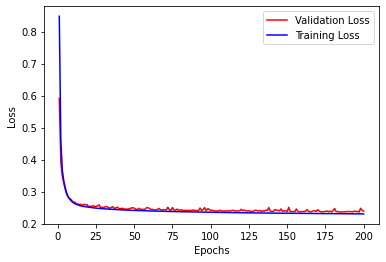

In [ ]:
# Plotting the variation of loss function on both training and validation set:

val_loss = history_detection.history["val_loss"]
loss     = history_detection.history["loss"]
epochs   = range(1, 201)
plt.plot(epochs, val_loss[:], "r-",
label="Validation Loss")
plt.plot(epochs, loss[:], "b-",
label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## **2.2  Evaluating the trained network over the testset**

In [ ]:
# Making predictions using the trained network:
predictions_label = model_detection.predict(X_tst_detection)

# Using argmax function to select the label with the highest probability.
y_pred = np.zeros([len(X_tst_detection),1])
for i in range(len(X_tst_detection)):
    y_pred[i,0] = np.argmax(predictions_label[i])

9375/9375 [==============================] - 13s 1ms/step


In [ ]:
#@title ##### Function for calculationg accuracy scores in e-DNN

def detection_score(y_pred,t_test):
  n_cc=1
  n_cs=1
  n_cr=1
  n_sc=1
  n_ss=1
  n_sr=1
  n_rc=1
  n_rs=1
  n_rr=1

  precip_c= 3
  precip_r= 2
  precip_s= 1

  for i in range(len(X_tst_detection)):
      label_predict = y_pred[i]
      label_actual = t_test[i]
      if label_predict==precip_c and label_actual==precip_c:
          n_cc+=1
      if label_predict==precip_s and label_actual==precip_s:
          n_ss+=1
      if label_predict==precip_r and label_actual==precip_r:
          n_rr+=1 
      if label_predict==precip_c and label_actual==precip_s:
          n_cs+=1
      if label_predict==precip_c and label_actual==precip_r:
          n_cr+=1
      if label_predict==precip_s and label_actual==precip_c:
          n_sc+=1
      if label_predict==precip_s and label_actual==precip_r:
          n_sr+=1  
      if label_predict==precip_r and label_actual==precip_c:
          n_rc+=1
      if label_predict==precip_r and label_actual==precip_s:
          n_rs+=1        
          
  #Snow
  TP_s = n_ss
  TN_s = n_cc+n_cr+n_rc+n_rr
  FP_s = n_sc+n_sr
  FN_s = n_cs+n_rs

  precision_s = TP_s/(TP_s+FP_s)
  acc_s       = (TP_s+TN_s)/(TP_s+TN_s+FP_s+FN_s)
  recall_s    = TP_s/(TP_s+FN_s)
  f1_score_s  = (2*precision_s*recall_s)/(precision_s+recall_s)
  FPR_s       = FP_s/(FP_s+TN_s)

  #Rain
  TP_r = n_rr
  TN_r = n_cc+n_cs+n_sc+n_ss
  FP_r = n_rc+n_rs
  FN_r = n_cr+n_sr

  precision_r = TP_r/(TP_r+FP_r)
  acc_r = (TP_r+TN_r)/(TP_r+TN_r+FP_r+FN_r)
  recall_r = TP_r/(TP_r+FN_r)
  f1_score_r = (2*precision_r*recall_r)/(precision_r+recall_r)
  FPR_r = FP_r/(FP_r+TN_r) 

  print('\n For Rainfall Detection Over Ocean:\n')
  print('Precision: ',precision_r)
  print('Accuracy: ',acc_r)
  print('Recall (TPR): ',recall_r)
  print('False Alarm (FPR): ',FPR_r)
  print('\nF1 Score: ',f1_score_r)

  print('----------------------------')
  print('\n For Snwofall Detection Over Ocean:\n')
  print('Precision: ',precision_s)
  print('Accuracy: ',acc_s)
  print('Recall (TPR): ',recall_s)
  print('False Alarm (FPR): ',FPR_s)
  print('\nF1 Score: ',f1_score_s)

  #Model
  TP = n_cc+n_ss+n_rr
  FP = n_cs+n_cr+n_sc+n_sr+n_rc+n_rs
  FN = n_sc+n_rc+n_cs+n_rs+n_cr+n_sr

  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  f1_score = (2*precision*recall)/(precision+recall)

  print('----------------------------')
  print('\n For Model Detection Over Ocean:\n')
  print('Precision: ',precision)
  print('Recall (TPR): ',recall)
  print('\nF1 Score: ',f1_score)

In [ ]:
detection_score(y_pred,t_test)


 For Rainfall Detection Over Ocean:

Precision:  0.9387613685578172
Accuracy:  0.9463205280375184
Recall (TPR):  0.9534477955515154
False Alarm (FPR):  0.06062684903314325

F1 Score:  0.9460475875262779
----------------------------

 For Snwofall Detection Over Ocean:

Precision:  0.9539180539630474
Accuracy:  0.9463205280375184
Recall (TPR):  0.9393705514106852
False Alarm (FPR):  0.046550156877694045

F1 Score:  0.9465884132070715
----------------------------

 For Model Detection Over Ocean:

Precision:  0.9463060533248415
Recall (TPR):  0.9463060533248415

F1 Score:  0.9463060533248415


 ### **2.1.2. Training the e-DNN**
 #### *a) Snowfall Retrieval*

In [ ]:
# This function defines the architecture of the snowfall estimation network with 4 layers.
# The activation function of the last layer is relu with 1 hidden unit which gives the predicted rate of snowfall in mm/hr.
# This fucntion also defines the callback list for early stopping. The training would be terminated if the value
# of loss function on the validation set does not improve for 25 consecutive epochs.
# The considered loss fuction is the root mean squared error, and 
# The optimization technique is RMSprop, which enables an adaptive choice of the learning rate.

from tensorflow.keras import backend
def root_mean_squared_error(y_true, y_pred):
        return backend.sqrt(backend.mean(backend.square(y_pred-y_true)))
    
def mean_absolute_error(y_true, y_pred):
        return backend.mean(backend.abs(y_pred-y_true))  

def RTV_snow(hidden_units, dropout):

  model_retrieval_snow = Sequential()

  model_retrieval_snow.add(Dense(hidden_units))
  model_retrieval_snow.add(Activation('relu'))
  model_retrieval_snow.add(Dropout(dropout))

  model_retrieval_snow.add(Dense(hidden_units))
  model_retrieval_snow.add(Activation('relu'))
  model_retrieval_snow.add(Dropout(dropout))

  model_retrieval_snow.add(Dense(hidden_units))
  model_retrieval_snow.add(Activation('relu'))
  model_retrieval_snow.add(Dropout(dropout))

  model_retrieval_snow.add(Dense(hidden_units))
  model_retrieval_snow.add(Activation('relu'))
  model_retrieval_snow.add(Dropout(dropout))

  model_retrieval_snow.add(Dense(1))
  model_retrieval_snow.add(Activation('relu'))
  model_retrieval_snow.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001),
              loss = root_mean_squared_error,
              metrics= mean_absolute_error)
  
  callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=25,),
    keras.callbacks.ModelCheckpoint(
    filepath="checkpoint_path.keras",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    )    
  ]  

  return model_retrieval_snow, callbacks_list


In [ ]:
model_retrieval_snow, callbacks_list = RTV_snow(75,0)
print('\nFitting DNN (Retrieval Module - Snow):\n')
batch_size2 = 600
history_retrieval_snow = model_retrieval_snow.fit(X_snow_trn_retrieval, y_snow_trn_retrieval, epochs=500,
                                validation_split=.2, batch_size = batch_size2,
                                callbacks=callbacks_list, verbose=1)

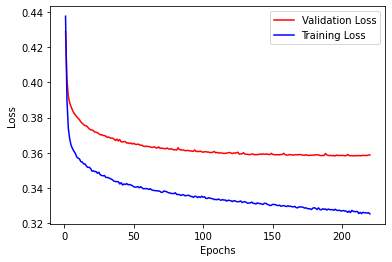

In [ ]:
val_loss = history_retrieval_snow.history["val_loss"]
loss = history_retrieval_snow.history["loss"]

epochs = range(1, 221)
plt.plot(epochs, val_loss[:], "r-",
label="Validation Loss")
plt.plot(epochs, loss[:], "b-",
label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# Evaluation of the snowfall retrieval results on the test set:
model_retrieval_snow.evaluate(X_snow_tst_retrieval, y_snow_tst_retrieval, batch_size = batch_size2)

500/500 [==============================] - 2s 4ms/step - loss: 0.3414 - mean_absolute_error: 0.1156


[0.34136825799942017, 0.1155814602971077]

 #### *b) Rainfall Retrieval*

In [ ]:
def RTV_rain(hidden_units, dropout):
  # OCEAN
  model_retrieval_rain = Sequential()

  model_retrieval_rain.add(Dense(hidden_units))
  model_retrieval_rain.add(Activation('relu'))
  model_retrieval_rain.add(Dropout(dropout))

  model_retrieval_rain.add(Dense(hidden_units))
  model_retrieval_rain.add(Activation('relu'))
  model_retrieval_rain.add(Dropout(dropout))

  model_retrieval_rain.add(Dense(hidden_units))
  model_retrieval_rain.add(Activation('relu'))
  model_retrieval_rain.add(Dropout(dropout))

  model_retrieval_rain.add(Dense(hidden_units))
  model_retrieval_rain.add(Activation('relu'))
  model_retrieval_rain.add(Dropout(dropout))


  model_retrieval_rain.add(Dense(1))
  model_retrieval_rain.add(Activation('relu'))

  model_retrieval_rain.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001),
              loss = mean_absolute_error,
              metrics= root_mean_squared_error)
  
  callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=25,),
    keras.callbacks.ReduceLROnPlateau
    (factor=0.1, patience=5, min_lr=0.00001, verbose=2),
    keras.callbacks.ModelCheckpoint(
    filepath="checkpoint_path.keras",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    )    
  ]
  return model_retrieval_rain, callbacks_list


In [ ]:
model_retrieval_rain, callbacks_list = RTV_rain(75,0)
batch_size2 = 600
history_retrieval_rain = model_retrieval_rain.fit(X_rain_trn_retrieval, y_rain_trn_retrieval, epochs=400,
                                validation_split=.2, batch_size = batch_size2,
                                callbacks=callbacks_list, verbose=1)

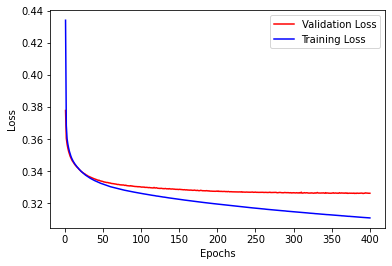

In [ ]:
val_loss = history_retrieval_rain.history["val_loss"]
loss     = history_retrieval_rain.history["loss"]
epochs   = range(1, 401)

plt.plot(epochs, val_loss[:], "r-",
label="Validation Loss")
plt.plot(epochs, loss[:], "b-",
label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
model_retrieval_rain.evaluate(X_rain_tst_retrieval, y_rain_tst_retrieval, batch_size = batch_size2)

500/500 [==============================] - 1s 2ms/step - loss: 0.3235 - root_mean_squared_error: 1.5126


[0.32350584864616394, 1.5126368999481201]

# **3.  Orbial Retrievals**

In this section, the pre-trained models are loaded to retrieve rainfall and snowfall for two GMI orbits. A simple visualization of these two orbits is shown below:

Orbit #3080:


 <center><img src ='https://drive.google.com/uc?id=1-4cKtPqxxBAJIgIbAa0lkjQD2Fa6j8lA' align = "left"></center>


Orbit #3498:


 <center><img src ='https://drive.google.com/uc?id=1-4oDIuI_fbwSLFC_p-o8REwRPPD-hbym' align = "left"></center>


## **3.1) Running DIEGO for the selected orbit**

In [ ]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import cartopy.ispydero.shapereader as shpreader
import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt
import cartopy.mpl.geoaxes
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline
import numpy as np
import os
import matplotlib        as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


There are two defined functions for retrieving orbital precipitation i) Load_Model, and ii) DIEGO_Net. The first function loads the trained network and calculated the mean and variance of the trainset, and the second function estimates the precipitation over the desired orbit. BIn the cell below these two functions is loaded.

In [ ]:
from Load_Model import *            # This function load the trained netwoks and their statistics

In [ ]:
# Select the orbit for retrieval
orbit_num = input("Enter the orbit number for retrieval: ")
os.chdir('/content/drive/My Drive/DNN-Github/Orbital')
my_files  = sorted(glob.glob('Orbit*dics.mat'))
orbit_num = my_files[0]

Enter the orbit number for retrieval: 3080


In [ ]:
#@title ##### Retreival functions
def DIEGO_RTV(my_files):
    orbit_num = my_files[0]
    orbit_num = orbit_num[0:9]
    labels = my_files[0]
    
    f_orbit = sio.loadmat(labels)
    ######################################### Inputs for Detection and Retrieval DNNs
    X0_detection = f_orbit['X_detection']
    X1_detection = np.transpose(X0_detection)
    X2_detection = np.transpose(X1_detection)
    #OCEAN
    X0_DPR_snow_ocean_retrieval = f_orbit['x_retrieval_DPR_snow_ocean']
    X1_DPR_snow_ocean_retrieval = np.transpose(X0_DPR_snow_ocean_retrieval)
    X0_DPR_rain_ocean_retrieval = f_orbit['x_retrieval_DPR_rain_ocean']
    X1_DPR_rain_ocean_retrieval = np.transpose(X0_DPR_rain_ocean_retrieval)
    X0_CPR_snow_ocean_retrieval = f_orbit['x_retrieval_CPR_ocean']
    X1_CPR_snow_ocean_retrieval = np.transpose(X0_CPR_snow_ocean_retrieval)
    X0_CPR_rain_ocean_retrieval = f_orbit['x_retrieval_CPR_rain_ocean']
    X1_CPR_rain_ocean_retrieval = np.transpose(X0_CPR_rain_ocean_retrieval)
    #LAND
    X0_DPR_snow_land_retrieval = f_orbit['x_retrieval_DPR_snow_land']
    X1_DPR_snow_land_retrieval = np.transpose(X0_DPR_snow_land_retrieval)
    X0_DPR_rain_land_retrieval = f_orbit['x_retrieval_DPR_rain_land']
    X1_DPR_rain_land_retrieval = np.transpose(X0_DPR_rain_land_retrieval)
    X0_CPR_snow_land_retrieval = f_orbit['x_retrieval_CPR_land']
    X1_CPR_snow_land_retrieval = np.transpose(X0_CPR_snow_land_retrieval)
    #COAST
    X0_DPR_snow_coast_retrieval = f_orbit['x_retrieval_DPR_snow_coast']
    X1_DPR_snow_coast_retrieval = np.transpose(X0_DPR_snow_coast_retrieval)
    X0_DPR_rain_coast_retrieval = f_orbit['x_retrieval_DPR_rain_coast']
    X1_DPR_rain_coast_retrieval = np.transpose(X0_DPR_rain_coast_retrieval)
    X0_CPR_snow_coast_retrieval = f_orbit['x_retrieval_CPR_coast']
    X1_CPR_snow_coast_retrieval = np.transpose(X0_CPR_snow_coast_retrieval)
    
    ######################################### Detection Inputs
    ###-------------- DPR:
    #OCEAN
    X3_detection_DPR_ocean = X2_detection-mean_detection_DPR_ocean
    X4_detection_DPR_ocean = X3_detection_DPR_ocean/std_detection_DPR_ocean
    X_detection_DPR_ocean = np.transpose(X4_detection_DPR_ocean)
    
    #LAND
    X3_detection_DPR_land = X2_detection-mean_detection_DPR_land
    X4_detection_DPR_land = X3_detection_DPR_land/std_detection_DPR_land
    X_detection_DPR_land = np.transpose(X4_detection_DPR_land)
    
    #COAST
    X3_detection_DPR_coast = X2_detection-mean_detection_DPR_coast
    X4_detection_DPR_coast = X3_detection_DPR_coast/std_detection_DPR_coast
    X_detection_DPR_coast = np.transpose(X4_detection_DPR_coast)    
    
    ###-------------- CPR:
    #OCEAN
    X3_detection_CPR_ocean = X2_detection-mean_detection_CPR_ocean
    X4_detection_CPR_ocean = X3_detection_CPR_ocean/std_detection_CPR_ocean
    X_detection_CPR_ocean = np.transpose(X4_detection_CPR_ocean)    
    
    #LAND
    X3_detection_CPR_land = X2_detection-mean_detection_CPR_land
    X4_detection_CPR_land = X3_detection_CPR_land/std_detection_CPR_land
    X_detection_CPR_land = np.transpose(X4_detection_CPR_land)    
    
    #COAST
    X3_detection_CPR_coast = X2_detection-mean_detection_CPR_coast
    X4_detection_CPR_coast = X3_detection_CPR_coast/std_detection_CPR_coast
    X_detection_CPR_coast = np.transpose(X4_detection_CPR_coast)        
     
    ######################################### Retrieval Inputs
    ###-------------- DPR (Rain):
    #OCEAN
    X2_DPR_rain_ocean_retrieval = X1_DPR_rain_ocean_retrieval-mean_rain_retrieval_DPR_ocean
    X3_DPR_rain_ocean_retrieval = X2_DPR_rain_ocean_retrieval/std_rain_retrieval_DPR_ocean
    X_DPR_rain_ocean_retrieval = np.transpose(X3_DPR_rain_ocean_retrieval)
    
    #LAND
    X2_DPR_rain_land_retrieval = X1_DPR_rain_land_retrieval-mean_rain_retrieval_DPR_land
    X3_DPR_rain_land_retrieval = X2_DPR_rain_land_retrieval/std_rain_retrieval_DPR_land
    X_DPR_rain_land_retrieval = np.transpose(X3_DPR_rain_land_retrieval)
    
    #COAST
    X2_DPR_rain_coast_retrieval = X1_DPR_rain_coast_retrieval-mean_rain_retrieval_DPR_coast
    X3_DPR_rain_coast_retrieval = X2_DPR_rain_coast_retrieval/std_rain_retrieval_DPR_coast
    X_DPR_rain_coast_retrieval = np.transpose(X3_DPR_rain_coast_retrieval)
    
    ###-------------- DPR (Snow):
    #OCEAN
    X2_DPR_snow_ocean_retrieval = X1_DPR_snow_ocean_retrieval-mean_snow_retrieval_DPR_ocean
    X3_DPR_snow_ocean_retrieval = X2_DPR_snow_ocean_retrieval/std_snow_retrieval_DPR_ocean
    X_DPR_snow_ocean_retrieval = np.transpose(X3_DPR_snow_ocean_retrieval)
    
    #LAND
    X2_DPR_snow_land_retrieval = X1_DPR_snow_land_retrieval-mean_snow_retrieval_DPR_land
    X3_DPR_snow_land_retrieval = X2_DPR_snow_land_retrieval/std_snow_retrieval_DPR_land
    X_DPR_snow_land_retrieval = np.transpose(X3_DPR_snow_land_retrieval)
    
    #COAST
    X2_DPR_snow_coast_retrieval = X1_DPR_snow_coast_retrieval-mean_snow_retrieval_DPR_coast
    X3_DPR_snow_coast_retrieval = X2_DPR_snow_coast_retrieval/std_snow_retrieval_DPR_coast
    X_DPR_snow_coast_retrieval = np.transpose(X3_DPR_snow_coast_retrieval)
    
    
    ###-------------- CPR (Snow):
    #OCEAN
    X2_CPR_snow_ocean_retrieval = X1_CPR_snow_ocean_retrieval-mean_snow_retrieval_CPR_ocean
    X3_CPR_snow_ocean_retrieval = X2_CPR_snow_ocean_retrieval/std_snow_retrieval_CPR_ocean
    X_CPR_snow_ocean_retrieval = np.transpose(X3_CPR_snow_ocean_retrieval)
    
    #LAND
    X2_CPR_snow_land_retrieval = X1_CPR_snow_land_retrieval-mean_snow_retrieval_CPR_land
    X3_CPR_snow_land_retrieval = X2_CPR_snow_land_retrieval/std_snow_retrieval_CPR_land
    X_CPR_snow_land_retrieval = np.transpose(X3_CPR_snow_land_retrieval)
    
    #COAST
    X2_CPR_snow_coast_retrieval = X1_CPR_snow_coast_retrieval-mean_snow_retrieval_CPR_coast
    X3_CPR_snow_coast_retrieval = X2_CPR_snow_coast_retrieval/std_snow_retrieval_CPR_coast
    X_CPR_snow_coast_retrieval = np.transpose(X3_CPR_snow_coast_retrieval)
    
    ###-------------- CPR (Rain):
    #OCEAN
    X2_CPR_rain_ocean_retrieval = X1_CPR_rain_ocean_retrieval-mean_rain_retrieval_CPR_ocean
    X3_CPR_rain_ocean_retrieval = X2_CPR_rain_ocean_retrieval/std_rain_retrieval_CPR_ocean
    X_CPR_rain_ocean_retrieval = np.transpose(X3_CPR_rain_ocean_retrieval)
    
    ######################################### Retrieval Module
    ###-------------- DPR:
    #OCEAN
    label_pred = model_dtc_DPR_ocean.predict(X_detection_DPR_ocean)    
    y_pred_DPR_ocean = np.zeros([len(label_pred),1])
    for j in range(len(label_pred)):
        y_pred_DPR_ocean[j,0] = np.argmax(label_pred[j])
    rate_snow_pred_DPR_ocean = model_rtv_snow_DPR_ocean.predict(X_DPR_snow_ocean_retrieval)
    rate_rain_pred_DPR_ocean = model_rtv_rain_DPR_ocean.predict(X_DPR_rain_ocean_retrieval)
    
    #LAND
    label_pred = model_dtc_DPR_land.predict(X_detection_DPR_land)
    y_pred_DPR_land = np.zeros([len(label_pred),1])
    for j in range(len(label_pred)):
        y_pred_DPR_land[j,0] = np.argmax(label_pred[j])
    rate_snow_pred_DPR_land = model_rtv_snow_DPR_land.predict(X_DPR_snow_land_retrieval)
    rate_rain_pred_DPR_land = model_rtv_rain_DPR_land.predict(X_DPR_rain_land_retrieval)
    
    #COAST
    label_pred = model_dtc_DPR_coast.predict(X_detection_DPR_coast)
    y_pred_DPR_coast = np.zeros([len(label_pred),1])
    for j in range(len(label_pred)):
        y_pred_DPR_coast[j,0] = np.argmax(label_pred[j])
    rate_snow_pred_DPR_coast = model_rtv_snow_DPR_coast.predict(X_DPR_snow_coast_retrieval)
    rate_rain_pred_DPR_coast = model_rtv_rain_DPR_coast.predict(X_DPR_rain_coast_retrieval)
    
    ###-------------- CPR:
    #OCEAN
    label_pred = model_dtc_CPR_ocean.predict(X_detection_CPR_ocean)
    y_pred_CPR_ocean = np.zeros([len(label_pred),1])
    for j in range(len(label_pred)):
        y_pred_CPR_ocean[j,0] = np.argmax(label_pred[j])
    rate_snow_pred_CPR_ocean = model_rtv_snow_CPR_ocean.predict(X_CPR_snow_ocean_retrieval)
    rate_rain_pred_CPR_ocean = model_rtv_rain_CPR_ocean.predict(X_CPR_rain_ocean_retrieval)
    
    #LAND
    label_pred = model_dtc_CPR_land.predict(X_detection_CPR_land)
    y_pred_CPR_land = np.zeros([len(label_pred),1])
    for j in range(len(label_pred)):
        y_pred_CPR_land[j,0] = np.argmax(label_pred[j])
    rate_snow_pred_CPR_land = model_rtv_snow_CPR_land.predict(X_CPR_snow_land_retrieval)
    
    #COAST
    label_pred = model_dtc_CPR_coast.predict(X_detection_CPR_coast)
    y_pred_CPR_coast = np.zeros([len(label_pred),1])
    for j in range(len(label_pred)):
        y_pred_CPR_coast[j,0] = np.argmax(label_pred[j])
    rate_snow_pred_CPR_coast = model_rtv_snow_CPR_coast.predict(X_CPR_snow_coast_retrieval)

    labels = {'label_pred_ocean_DPR': y_pred_DPR_ocean,
                        'label_pred_ocean_CPR': y_pred_CPR_ocean,
                        'label_pred_land_DPR': y_pred_DPR_land,
                        'label_pred_land_CPR': y_pred_CPR_land,
                        'label_pred_coast_DPR': y_pred_DPR_coast,
                        'label_pred_coast_CPR': y_pred_CPR_coast}
    rate = {'rate_snow_pred_ocean_DPR': rate_snow_pred_DPR_ocean,
                            'rate_rain_pred_ocean_DPR': rate_rain_pred_DPR_ocean,
                            'rate_snow_pred_land_DPR': rate_snow_pred_DPR_land,
                            'rate_rain_pred_land_DPR': rate_rain_pred_DPR_land,
                            'rate_snow_pred_coast_DPR': rate_snow_pred_DPR_coast,
                            'rate_rain_pred_coast_DPR': rate_rain_pred_DPR_coast,
                            'rate_pred_ocean_CPR': rate_snow_pred_CPR_ocean,
                            'rate_rain_pred_ocean_CPR': rate_rain_pred_CPR_ocean,
                            'rate_pred_land_CPR': rate_snow_pred_CPR_land,                 
                            'rate_pred_coast_CPR': rate_snow_pred_CPR_coast}
    
    my_files_gprof = orbit_num +'.mat'
    GPROF = sio.loadmat(my_files_gprof)
    X = GPROF['X']
    A2_GPROF = GPROF['A2_GPROF']
    SurfType = A2_GPROF[0,0]['surfaceType']
    Lat = X[0,0]['lat_s1']
    Lon = X[0,0]['lon_s1']
    [n1, n2] = Lat.shape
    
    X_precip_label_DPR = np.zeros((n1,n2))
    X_precip_label_CPR = np.zeros((n1,n2))
    X_snow_DPR = np.zeros((n1,n2))
    X_rain_DPR = np.zeros((n1,n2))
    X_rain_CPR = np.zeros((n1,n2))
    X_snow_CPR = np.zeros((n1,n2))
    
    for z in range(n1*n2):
        [idx_i, idx_j] = np.unravel_index(z,(n1,n2),'F')
        if SurfType[idx_i, idx_j]==0:
            X_precip_label_DPR[idx_i, idx_j] = y_pred_DPR_ocean[z,0]
            X_precip_label_CPR[idx_i, idx_j] = y_pred_CPR_ocean[z,0]
        elif SurfType[idx_i, idx_j]==1:
            X_precip_label_DPR [idx_i, idx_j] = y_pred_DPR_land[z,0]
            X_precip_label_CPR [idx_i, idx_j] = y_pred_CPR_land[z,0]
        elif SurfType[idx_i, idx_j] ==2:
            X_precip_label_DPR [idx_i, idx_j] = y_pred_DPR_coast[z,0]
            X_precip_label_CPR [idx_i, idx_j] = y_pred_CPR_coast[z,0]
        elif SurfType[idx_i, idx_j]!=0 and SurfType[idx_i, idx_j]!=1  and SurfType[idx_i, idx_j]!=2 and ~np.isnan(SurfType[idx_i, idx_j]):
            X_precip_label_DPR [idx_i, idx_j] = y_pred_DPR_land[z,0]
            X_precip_label_CPR [idx_i, idx_j] = y_pred_CPR_land[z,0]
            
    for z in range(n1*n2):
        [idx_i, idx_j] = np.unravel_index(z,(n1,n2),'F')
        if SurfType[idx_i, idx_j]==0 and X_precip_label_DPR[idx_i, idx_j]==1:
            X_rain_DPR[idx_i, idx_j] = rate_rain_pred_DPR_ocean[z,0]
            
        elif SurfType[idx_i, idx_j]==1 and X_precip_label_DPR[idx_i, idx_j]==1:
            X_rain_DPR[idx_i, idx_j]= rate_rain_pred_DPR_land[z,0]
            
        elif SurfType[idx_i, idx_j]==2 and X_precip_label_DPR[idx_i, idx_j]==1:
            X_rain_DPR[idx_i, idx_j] = rate_rain_pred_DPR_coast[z,0]
            
        elif SurfType[idx_i, idx_j]==0 and X_precip_label_DPR[idx_i, idx_j]==2:
            X_snow_DPR[idx_i, idx_j] = rate_snow_pred_DPR_ocean[z,0]
            
        elif SurfType[idx_i, idx_j]==1 and X_precip_label_DPR[idx_i, idx_j]==2:
            X_snow_DPR[idx_i, idx_j]= rate_snow_pred_DPR_land[z,0]
            
        elif SurfType[idx_i, idx_j]==2 and X_precip_label_DPR[idx_i, idx_j]==2:
            X_snow_DPR[idx_i, idx_j] = rate_snow_pred_DPR_coast[z,0]
            
        elif (SurfType[idx_i, idx_j]!=0 and SurfType[idx_i, idx_j]!=1  and SurfType[idx_i, idx_j]!=2 
              and ~np.isnan(SurfType[idx_i, idx_j]) and X_precip_label_DPR[idx_i, idx_j]==1):
            X_rain_DPR[idx_i, idx_j] = rate_rain_pred_DPR_land[z,0]
            
        elif (SurfType[idx_i, idx_j]!=0 and SurfType[idx_i, idx_j]!=1  and SurfType[idx_i, idx_j]!=2 
              and ~np.isnan(SurfType[idx_i, idx_j]) and X_precip_label_DPR[idx_i, idx_j]==2):
            X_snow_DPR[idx_i, idx_j] =rate_snow_pred_DPR_ocean[z,0]
            
    for z in range(n1*n2):
        [idx_i, idx_j] = np.unravel_index(z, (n1, n2), 'F')
        if SurfType[idx_i, idx_j]==0 and X_precip_label_CPR[idx_i, idx_j]==2:
            X_snow_CPR[idx_i, idx_j] = rate_snow_pred_CPR_ocean[z,0]
            
        elif SurfType[idx_i, idx_j]==1 and X_precip_label_CPR[idx_i, idx_j]==2:
            X_snow_CPR[idx_i, idx_j] = rate_snow_pred_CPR_land[z,0]
            
        elif  SurfType[idx_i, idx_j]==2  and X_precip_label_CPR[idx_i, idx_j]==2:
            X_snow_CPR[idx_i, idx_j] = rate_snow_pred_CPR_coast[z,0]
            
        elif SurfType[idx_i, idx_j]==0 and X_precip_label_CPR[idx_i, idx_j]==1:
            X_rain_CPR[idx_i, idx_j]= rate_rain_pred_CPR_ocean[z,0]
            
        elif (SurfType[idx_i, idx_j]!=0 and SurfType[idx_i, idx_j]!=1  and SurfType[idx_i, idx_j]!=2 
              and ~np.isnan(SurfType[idx_i, idx_j]) and X_precip_label_CPR[idx_i, idx_j]==2):
            X_snow_CPR[idx_i, idx_j] = rate_snow_pred_CPR_land[z,0]
    X_rain = np.zeros((n1,n2))
    X_snow = np.zeros((n1,n2))
    X_mix = np.zeros((n1,n2))
    w_cpr = 0.5
    w_dpr = 0.5
    
    for i in range(n1):
        for j in range(n2):
            if X_snow_CPR[i,j]>0.01 and X_snow_DPR[i,j] <0.01:
                X_snow[i,j] = X_snow_CPR[i,j]
            elif X_snow_CPR[i,j]<0.01 and X_snow_DPR[i,j]>0.01:
                X_snow[i,j] = X_snow_DPR[i,j]
            elif X_snow_CPR[i,j]>0.01 and X_snow_DPR[i,j]>0.01:
                X_snow[i,j] = w_cpr*X_snow_CPR[i,j] + w_dpr*X_snow_DPR[i,j]
            elif X_snow_CPR[i,j]<0.01 and X_snow_DPR[i,j] <0.01:
                X_snow[i,j] = 0
               
    for i in range(n1):
        for j in range(n2):
            if X_rain_CPR[i,j]>0.01 and X_rain_DPR[i,j] <0.01:
                X_rain[i,j] = X_rain_CPR[i,j]
            elif X_rain_CPR[i,j]<0.01 and X_rain_DPR[i,j]>0.01:
                X_rain[i,j] = X_rain_DPR[i,j]
            elif X_rain_CPR[i,j]>0.01 and X_rain_DPR[i,j]>0.01:
                X_rain[i,j] = w_cpr*X_rain_CPR[i,j] + w_dpr*X_rain_DPR[i,j]
            elif X_rain_CPR[i,j]<0.01 and X_rain_DPR[i,j] <0.01:
                X_rain[i,j] = 0
           
    for i in range(n1):
        for j in range(n2):
            if X_snow[i,j]>0.01 and X_rain[i,j]>0.01:
                X_mix[i,j] = np.maximum(X_snow[i,j], X_rain[i,j])
                X_snow[i,j] = 0;
                X_rain[i,j] = 0

    return X_rain, X_snow, X_mix, X_rain_DPR, X_snow_DPR, X_rain_CPR, X_snow_CPR, Lat, Lon, labels, rate

                

Using the DIEGO_RTV function for retrieving the precipitation. This function receives the defined features for each orbit as the input for d-DNN and e-DNN (see section 1.2). As previously mentioned, different networks are trained for retrievals, using DPR and CPR dataset. For each surface type, we have two d-DNNs and four e-DNNs. In a storm-scale, we present combined retrievals through a simple fusion approach as explained in the paper. Therefore the output of DIEGO_RTV function is as follows:


1.   Combined Retrieved rainfall rate (X_rain) 
2.   Combined retrieved snowfall rate (X_snow)
3.   Retrieved rainfall rate using DPR dataset (X_rain_DPR)
4.   Retrieved snowfall rate using DPR dataset (X_snow_DPR)
5.   Retrieved rainfall rate using CPR dataset  (X_rain_CPR)
6.   Retrieved snowfall rate using COR dataset (X_snow_CPR)
7.   Latitude, and longitude for the selected pixle. (Lat, Lon)




In [ ]:
X_rain, X_snow, X_mix, X_rain_DPR, X_snow_DPR, X_rain_CPR, X_snow_CPR, Lat, Lon, labels, rate = DIEGO_RTV(my_files)

In [ ]:
# The retrieved rainfall and snowfall rates can be compared by the estimation of 
# GPROF, ERA5 and acrive radar DPR retrievals
orbit      = sio.loadmat('Orbit3080.mat')
A2_DPR     = orbit['A2_DPR']
Lat_DPR    = A2_DPR['Lat'][0,0]
Lon_DPR    = A2_DPR['Lon'][0,0]
rain_DPR   = A2_DPR['rain'][0,0]
snow_DPR   = A2_DPR['snow'][0,0]
A2_GPROF   = orbit['A2_GPROF']
GPROF_rain = A2_GPROF['SurfPrecip'][0,0]
GPROF_snow = A2_GPROF['FrozenPrecip'][0,0]
X = orbit['X']
TB = X['TB'][0,0]
ERA5_rain = X['ERA5_RR'][0,0]
ERA5_snow = X['ERA5_SR'][0,0]

# loading the colormaps
Cmap = sio.loadmat('colormap.mat')
cmap_rain = Cmap['Cmap_rain']
cmap_snow = Cmap['Cmap_snow']
cmap_mix  = Cmap['Cmap_mix']
cmap_snow = mpl.colors.ListedColormap(cmap_snow, name='myColorMap', N=cmap_snow.shape[0])
cmap_rain = mpl.colors.ListedColormap(cmap_rain, name='myColorMap', N=cmap_rain.shape[0])
cmap_mix  = mpl.colors.ListedColormap(cmap_mix, name='myColorMap', N=cmap_mix.shape[0])
colorlist_rain=["darkorange", "gold", "lawngreen", "lightseagreen"]
cmap_rain = LinearSegmentedColormap.from_list('testCmap', colors=colorlist_rain, N=256)
cmap_rain = cmap_rain.reversed()
colorlist_mix=["snow", "magenta"]
cmap_mix  = LinearSegmentedColormap.from_list('testCmap', colors=colorlist_mix, N=100)


In [ ]:
# Quantizing the range of precipitation

def precip_quantize(R,cbar,s_r):
    idx    = np.isnan(R)
    R[idx] = 0
    R[R<0] = 0
    level  = np.array([0.01, 0.5, 1, 2, 4, 8, 16, 32,64])
    sub_level   = level[:cbar]
    sub_level_i = np.zeros(cbar*s_r)
    for i in range(len(level)-1):
        sub_level_i[s_r*(i):s_r*(i)+s_r] = np.linspace(level[i], level[i+1],s_r)
    sub_level_i = np.delete(sub_level_i, [4,8,12,16,20,24,28])
    Rps = np.digitize(R, sub_level_i)
    Rps = Rps.astype(float)
    idx = Rps==0
    Rps[idx] = np.nan
    return(Rps)

##################### DIEGO ###################################
R_rain = precip_quantize(X_rain,8,4)
R_snow = precip_quantize(X_snow,8,4)
R_mix  = precip_quantize(X_mix,8,4)

##################### DPR ###################################
R_rain_DPR = precip_quantize(X_rain_DPR,8,4)
R_snow_DPR = precip_quantize(X_snow_DPR,8,4)

##################### CPR ###################################
R_rain_CPR = precip_quantize(X_rain_CPR,8,4)
R_snow_CPR = precip_quantize(X_snow_CPR,8,4)

##################### DPR actual #############################
R_rain_DPR_act = precip_quantize(rain_DPR,8,4)
R_snow_DPR_act = precip_quantize(snow_DPR,8,4)

##################### GPROF actual #############################
R_rain_GPROF_act = precip_quantize(GPROF_rain,8,4)
R_snow_GPROF_act = precip_quantize(GPROF_snow,8,4)

##################### ERA5 ###################################
R_rain_ERA5 = precip_quantize(ERA5_rain,8,4)
R_snow_ERA5 = precip_quantize(ERA5_snow,8,4)


In [ ]:
#@title ##### Visualization functions

# Three different functions are developed to 
def plot_RTV_TB(TB, Lat, Lon, levels, zone):
    """Function to plot Brightness Temperatures"""
    # zone is the limt of lat and lon for the figure [latMin, lonMin, latMax, lonMax]
    fig      = plt.subplots(figsize=(15, 30))
    im_ratio = R_rain.shape[0]/R_rain.shape[1]

    ax1   = plt.subplot(131,projection = ccrs.Mercator())
    plot1 = plt. contourf(Lon, Lat, TB[5,:,:], levels, cmap = 'jet',vmin = 180, vmax = 280, transform=ccrs.PlateCarree())
    ax1.coastlines()
    ax1.gridlines(draw_labels = True)
    ax1.set_extent(zone ccrs.PlateCarree())  
    ax1.text(-37, 60.2, '37 GHz', fontsize=14, transform=ccrs.PlateCarree())

    ax2   = plt.subplot(132,projection = ccrs.Mercator())
    plot2 = plt. contourf(Lon, Lat, TB[7,:,:],levels, cmap = 'jet', transform=ccrs.PlateCarree(),vmin = 180, vmax = 280)
    ax2.coastlines()
    ax2.gridlines(draw_labels = False)
    ax2.set_extent(zone ccrs.PlateCarree()) 
    ax2.text(-37, 60.2, '89 GHz', fontsize=14, transform=ccrs.PlateCarree())

    ax3   = plt.subplot(133,projection = ccrs.Mercator())
    plot3 = plt. contourf(Lon, Lat, TB[9,:,:],levels = np.linspace(180, 280, 100), cmap = 'jet', transform=ccrs.PlateCarree())
    ax3.coastlines()
    ax3.gridlines(draw_labels = False)
    ax3.set_extent(zone, ccrs.PlateCarree()) 
    ax3.text(-38, 60.2, '166 GHz', fontsize=14, transform=ccrs.PlateCarree())
    plt.colorbar(plot3,ax = [ax3], location = 'right',fraction=0.42*im_ratio)
    plt.show()

def plot_RTV_Precipitation( Lat, Lon,R_rain,R_snow, R_rain_DPR, R_snow_DPR, R_rain_CPR, R_snow_CPR, R_mix, level, zones):
    """Function to plot precipitation"""
    # mix defines if we want to plot mix values or not
    im_ratio = R_rain.shape[0]/R_rain.shape[1]

    fig   = plt.subplots(figsize=(15, 30))
    ax1   = plt.subplot(131,projection = ccrs.Mercator())
    plot1 = plt. contourf(Lon, Lat, R_rain_DPR, np.linspace(1, 12, level), cmap = cmap_rain, transform=ccrs.PlateCarree(), vmin =0, vmax = 12)
    plot2 = plt. contourf(Lon, Lat, R_snow_DPR, np.linspace(1, 10, level), cmap = cmap_snow, transform=ccrs.PlateCarree(), vmin =0, vmax = 10)

    ax1.coastlines()
    ax1.gridlines(draw_labels = True)
    plt.tick_params(right = False, top = False)
    ax1.set_extent(zones, ccrs.PlateCarree())
    ax1.text(-40, 60.2, 'DIEGO DPR', fontsize=14, transform=ccrs.PlateCarree())
    ax1.text(-51, 57.7, 'Snow $\mathrm{[mm.hr^{-1}]}$', fontsize=14, transform=ccrs.PlateCarree())
    plot1.top_labels = False
    plot1.left_labels = False
    plot2.top_labels = False
    plot2.left_labels = False
    #plt.colorbar(plot2,ax = [ax1], location = 'bottom')
    Ticks = np.arange(0,np.nanmax(R_snow_DPR),2)
    cax = ax1.inset_axes([0, -0.3, 1, 0.05])
    cbar1 = plt.colorbar(plot2,ax = [ax1], cax = cax, orientation="horizontal",ticks=Ticks)
    cbar1.set_ticklabels(['0', '0.5', '1', '2', '4', '8','16','18'])
    
    ax2    = plt.subplot(132,projection = ccrs.Mercator())
    plot21 = plt. contourf(Lon, Lat, R_rain_CPR, np.linspace(0, 12, level), cmap = cmap_rain, transform=ccrs.PlateCarree(), vmin =0, vmax = 12)
    plot22 = plt. contourf(Lon, Lat, R_snow_CPR, np.linspace(0, 10, level), cmap = cmap_snow, transform=ccrs.PlateCarree(), vmin =0, vmax = 10)
    ax2.coastlines()
    ax2.gridlines(draw_labels = False)
    ax2.set_extent(zones, ccrs.PlateCarree())
    ax2.text(-40, 60.2, 'DIEGO CPR', fontsize=14, transform=ccrs.PlateCarree())
    ax2.text(-47,  57.7, 'Rain', fontsize=14, transform=ccrs.PlateCarree())
    #plt.colorbar(plot22,ax = [ax2], location = 'bottom')
    Ticks = np.arange(0,np.nanmax(R_rain_CPR),2)
    cax = ax2.inset_axes([0, -0.3, 1, 0.05])
    cbar2 = plt.colorbar(plot21,ax = [ax2], cax = cax, orientation="horizontal",ticks=Ticks)
    cbar2.set_ticklabels(['0', '0.5', '1', '2', '4', '8','16', '32'])

    ax3 = plt.subplot(133,projection = ccrs.Mercator())
    plot31 = plt. contourf(Lon, Lat, R_mix, np.linspace(0, 8, level), cmap = cmap_mix, transform=ccrs.PlateCarree(), vmin =0, vmax = 8)
    plot32 = plt. contourf(Lon, Lat, R_snow, np.linspace(0, 10, level), cmap = cmap_snow, transform=ccrs.PlateCarree(), vmin =0, vmax = 10)
    plot33 = plt. contourf(Lon, Lat, R_rain, np.linspace(0, 12, level), cmap = cmap_rain, transform=ccrs.PlateCarree(), vmin =0, vmax = 12)
    ax3.coastlines()
    g1 = ax3.gridlines(draw_labels = False)
    ax3.set_extent(zones, ccrs.PlateCarree())
    ax3.text(-38, 60.2, 'DIEGO', fontsize=14, transform=ccrs.PlateCarree())
    ax3.text(-47,  57.7, 'Mix', fontsize=14, transform=ccrs.PlateCarree())
    Ticks = np.arange(0,np.nanmax(R_mix),2)
    cax = ax3.inset_axes([0, -0.3, 1, 0.05])
    cbar3 = plt.colorbar(plot31,ax = [ax3], cax = cax, orientation="horizontal",ticks=Ticks)
    cbar3.set_ticklabels(['0', '0.5', '1', '2', '4', '8','16'])  
    plt.show()
    
def plot_REF_Precipitation( Lat, Lon, Lat_DPR, Lon_DPR, R_rain_GPROF_act,R_snow_GPROF_act, R_rain_ERA5, R_snow_ERA5, R_rain_DPR_act, R_snow_DPR_act, level, zones):
    im_ratio = R_snow_GPROF_act.shape[0]/R_snow_GPROF_act.shape[1]
    fig = plt.subplots(figsize=(15, 30))
    ax1 = plt.subplot(131,projection = ccrs.Mercator())
    plot1 = plt. contourf(Lon, Lat, R_rain_GPROF_act, np.linspace(1, 16, level), cmap = cmap_rain, transform=ccrs.PlateCarree(), vmin =0, vmax = 16)
    plot2 = plt. contourf(Lon, Lat, R_snow_GPROF_act, np.linspace(0, 12, level), cmap = cmap_snow, transform=ccrs.PlateCarree(), vmin =0, vmax = 12)
    ax1.coastlines()
    ax1.gridlines(draw_labels = True)
    plt.tick_params(right = False, top = False)
    ax1.set_extent([-60, -30, 60, 68], ccrs.PlateCarree())
    ax1.text(-38, 60.2, 'GPROF', fontsize=14, transform=ccrs.PlateCarree())
    #plt.colorbar(plot2,ax = [ax1], location = 'bottom')
    Ticks = np.arange(0,np.nanmax(R_snow_GPROF_act),2)
    cax = ax1.inset_axes([0.5, -0.3, 1, 0.05])
    cbar1 = plt.colorbar(plot2,ax = [ax1], cax = cax, orientation="horizontal",ticks=Ticks)
    cbar1.set_ticklabels(['0', '0.5', '1', '2', '4', '8','16','18','20'])
    ax1.text(-35,  58.0, 'Snow $\mathrm{[mm.hr^{-1}]}$', fontsize=14, transform=ccrs.PlateCarree())
    
    ax2 = plt.subplot(132,projection = ccrs.Mercator())
    plot21 = plt. contourf(Lon, Lat, R_rain_ERA5, np.linspace(0, 12, level), cmap = cmap_rain, transform=ccrs.PlateCarree(), vmin =0, vmax = 12)
    plot22 = plt. contourf(Lon, Lat, R_snow_ERA5, np.linspace(0, 12, level), cmap = cmap_snow, transform=ccrs.PlateCarree(), vmin =0, vmax = 12)
    ax2.coastlines()
    ax2.gridlines(draw_labels = False)
    ax2.set_extent([-60, -30, 60, 68], ccrs.PlateCarree())
    ax2.text(-36, 60.2, 'ERA5', fontsize=14, transform=ccrs.PlateCarree())
    Ticks = np.arange(0,np.nanmax(R_rain_ERA5),2)
    cax = ax2.inset_axes([0.5, -0.3, 0.95, 0.05])
    cbar2 = plt.colorbar(plot21,ax = [ax2], cax = cax,orientation="horizontal")
    cbar2.set_ticklabels(['0', '0.5', '1', '2', '4', '8','16','18','20'])
    ax2.text(-32,  58.0, 'Rain', fontsize=14, transform=ccrs.PlateCarree())

    ax3 = plt.subplot(133,projection = ccrs.Mercator())
    plot31 = plt. contourf(Lon_DPR, Lat_DPR, R_rain_DPR_act, np.linspace(0, 12, level), cmap = cmap_rain, transform=ccrs.PlateCarree(), vmin =0, vmax = 12)
    plot32 = plt. contourf(Lon_DPR, Lat_DPR, R_snow_DPR_act, np.linspace(0, 12, level), cmap = cmap_snow, transform=ccrs.PlateCarree(), vmin =0, vmax = 12)
    ax3.coastlines()
    g1 = ax3.gridlines(draw_labels = False)
    ax3.set_extent([-60, -30, 60, 68], ccrs.PlateCarree())
    ax3.text(-35, 60.2, 'DPR', fontsize=14, transform=ccrs.PlateCarree()) 
    plt.show()

## **3.2) Visualizing and Comparisons**



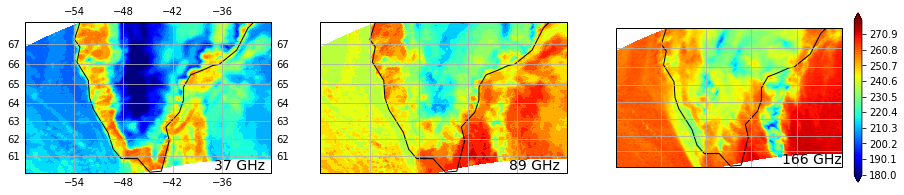

In [ ]:
# TBs at three GMI frequency channels 
plot_RTV_TB(TB, Lat, Lon, 50, [-60, -30, 60, 68])

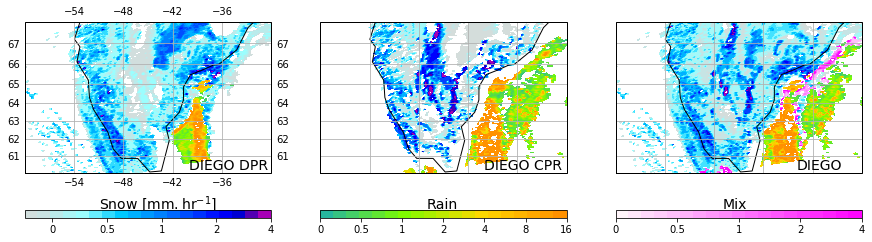

In [ ]:
# DIEGO retrievals
plot_RTV_Precipitation(Lat, Lon, R_rain,R_snow, R_rain_DPR, R_snow_DPR, R_rain_CPR, R_snow_CPR, R_mix,20, [-60, -30, 60, 68])

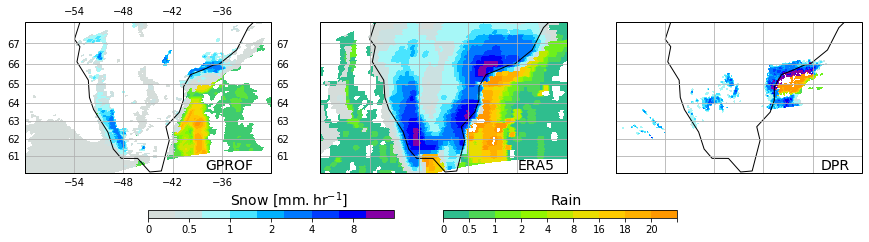

In [ ]:
# Precipitation from GPROF (V07), ERA5, and DPR
plot_REF_Precipitation(Lat, Lon, Lat_DPR, Lon_DPR, R_rain_GPROF_act,R_snow_GPROF_act, R_rain_ERA5, R_snow_ERA5, R_rain_DPR_act, R_snow_DPR_act, 10,[-60, -30, 60, 68])